In [1]:
import numpy as np
import joblib
from setfit import SetFitModel
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
import json
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

#### Test Data -> annotated.json

In [2]:
def clean_text(text: str) -> str:
    """Lowercase, strip, replace - and / with spaces."""
    return str(text).lower().strip().replace("-", " ").replace("/", " ")

In [19]:
data = pd.read_csv(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/highest_active_jobs.csv",
)

X_texts = data["position"].astype(str).apply(clean_text)
y_true = data["department"].astype(str)

encoder = joblib.load("/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/encoder_department.joblib")

class_order = np.array(getattr(encoder, "classes_", None), dtype=object)
if class_order.size == 0:
    raise ValueError("Encoder does not provide 'classes_'. Provide class order explicitly.")

y_true_encoded = encoder.transform(y_true)

#### Pipeline

In [21]:
# Load BOW + Logistic Regression Model
bow_lr_model = joblib.load("/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/bow_department.joblib")

bow_lr_model

Pipeline(steps=[('bow', CountVectorizer(max_df=0.9, ngram_range=(1, 2))),
                ('ros', RandomOverSampler(random_state=123)),
                ('clf',
                 LogisticRegression(C=10, max_iter=2000, solver='liblinear'))])

In [22]:
# Huggingface Model
model_hf = SetFitModel.from_pretrained(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/department-classifier-v2",
    local_files_only=True
)

The tokenizer you are loading from '/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/department-classifier-v2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


In [23]:
enc_order = list(encoder.classes_)
hf_labels = list(model_hf.labels)

idx = [hf_labels.index(c) for c in enc_order]

aligned_label_order = [hf_labels[i] for i in idx]
print("HF labels (original):", hf_labels)
print("HF labels (reordered):", aligned_label_order)
print("Encoder order:", enc_order)

assert aligned_label_order == enc_order, "Alignment failed: reordered HF labels != encoder order"


HF labels (original): ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']
HF labels (reordered): ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']
Encoder order: ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']


In [24]:
def align_proba_to_class_order(model_hf, texts, class_order):
    """
    SetFit predict_proba columns are in model_hf.labels order.
    Reorder them to match class_order.
    """
    P = np.asarray(model_hf.predict_proba(texts))
    hf_labels = list(model_hf.labels)

    # map each class in class_order to its column index in SetFit output
    try:
        idx = [hf_labels.index(c) for c in class_order]
    except ValueError as e:
        missing = [c for c in class_order if c not in hf_labels]
        raise ValueError(f"SetFit model is missing labels: {missing}") from e

    return P[:, idx]


def soft_vote_predict_proba(model_bow, model_hf, texts, class_order, w_bow=0.2, w_hf=0.8):
    """
    Weighted soft-voting ensemble over class probabilities.
    Returns:
      - y_pred (string labels)
      - P_ens  (aligned probabilities in class_order)
    """
    texts = list(texts)

    P_bow = np.asarray(model_bow.predict_proba(texts))
    P_hf  = align_proba_to_class_order(model_hf, texts, class_order)

    if P_bow.shape != P_hf.shape:
        raise ValueError(f"Shape mismatch: P_bow {P_bow.shape} vs P_hf {P_hf.shape}")

    w_sum = (w_bow + w_hf)
    if w_sum <= 0:
        raise ValueError("Weights must sum to a positive number.")

    P_ens = (w_bow * P_bow + w_hf * P_hf) / w_sum
    y_pred = class_order[np.argmax(P_ens, axis=1)]
    return y_pred, P_ens


def evaluate(name, y_true, y_pred, labels):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"{name} Macro F1:  {f1m:.4f}")
    return acc, f1m

y_pred_hf = np.array(model_hf.predict(X_texts), dtype=object)
evaluate("SetFit", y_true, y_pred_hf, labels=class_order)

y_pred_ens, P_ens = soft_vote_predict_proba(
    bow_lr_model, model_hf, X_texts, class_order,
    w_bow=0.2, w_hf=0.8
)

evaluate("SoftVote", y_true, y_pred_ens, labels=class_order)

print("\nSoftVote classification report:")
print(classification_report(
    y_true, y_pred_ens,
    labels=class_order,
    target_names=class_order,
    zero_division=0
))

SetFit Accuracy: 0.7092
SetFit Macro F1:  0.5571
SoftVote Accuracy: 0.7176
SoftVote Macro F1:  0.5785

SoftVote classification report:
                        precision    recall  f1-score   support

        Administrative       0.40      0.18      0.25        11
  Business Development       0.67      0.25      0.36        16
            Consulting       0.67      0.60      0.63        30
      Customer Support       0.60      0.60      0.60         5
       Human Resources       0.75      0.64      0.69        14
Information Technology       0.64      0.52      0.57        56
             Marketing       0.64      0.35      0.45        20
                 Other       0.76      0.88      0.81       248
    Project Management       0.68      0.63      0.66        30
            Purchasing       0.50      0.75      0.60        12
                 Sales       0.74      0.72      0.73        36

              accuracy                           0.72       478
             macro avg       0.

<Figure size 12000x12000 with 0 Axes>

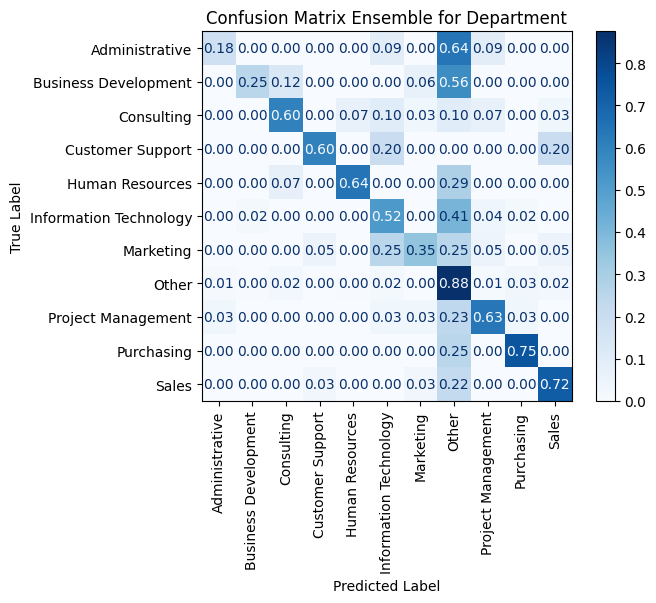

In [25]:
cm_norm = confusion_matrix(
    y_true,
    y_pred_ens,
    normalize="true"
)

plt.figure(figsize=(20, 20), dpi=600)

display = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=encoder.classes_)
display.plot(cmap="Blues", xticks_rotation=90, values_format=".2f")

plt.title("Confusion Matrix Ensemble for Department")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("plots/cm_ensemble_department.png", bbox_inches="tight")
plt.show()

Compare with Huggingface model alone

In [26]:
y_pred_hf = np.array(model_hf.predict(X_texts), dtype=object)

print("HF Accuracy:", accuracy_score(y_true, y_pred_hf))
print("HF Macro F1:", f1_score(y_true, y_pred_hf, average="macro"))
print(classification_report(
    y_true, y_pred_hf,
    labels=enc_order, target_names=enc_order,
    zero_division=0
))


HF Accuracy: 0.7092050209205021
HF Macro F1: 0.5570969962853601
                        precision    recall  f1-score   support

        Administrative       0.33      0.18      0.24        11
  Business Development       0.57      0.25      0.35        16
            Consulting       0.64      0.60      0.62        30
      Customer Support       0.50      0.40      0.44         5
       Human Resources       0.75      0.64      0.69        14
Information Technology       0.65      0.50      0.57        56
             Marketing       0.64      0.35      0.45        20
                 Other       0.76      0.86      0.81       248
    Project Management       0.69      0.67      0.68        30
            Purchasing       0.45      0.75      0.56        12
                 Sales       0.72      0.72      0.72        36

              accuracy                           0.71       478
             macro avg       0.61      0.54      0.56       478
          weighted avg       0.70     